La librería estándar de Python incluye datetime, con tipos específicos para almacenar fechas y tiempos. Están pensados para ser versátiles, pero no son especialmente rápidos

In [1]:
from datetime import date, datetime, timedelta

today = date.today()
print(today)

2016-12-22


El módulo para cálculo numérico numpy también incluye un tipo para almacenar fechas y tiempos. A diferencia de datetime, sí está pensado para ser eficiente.

In [2]:
import numpy as np
today_fast = np.datetime64(date.today())
print(today_fast)

2016-12-22


Si comprobamos el tipo que almacena el array today_fast vemos que se trata de una cantidad de ocho bytes, y con la anotación D de día. Esta anotación es importante porque hay que tener en cuenta cómo se trata de manera interna el tiempo en numpy.

In [4]:
print(type(today))
print(today_fast.dtype)

<class 'datetime.date'>
datetime64[D]


El tiempo es un número entero que empieza a contar el 1 de enero de 1970, pero depende de si contamos días, meses, horas o microsegundos. Por eso la anotación es importante. En el caso de today_fast, la fecha de hoy se almacena como los 17157 días que han trascurrido desde la fecha de referencia.

In [5]:
today_fast.astype(np.int)

17157

Pero, como se ha dicho justo antes, no es lo mismo contar días que microsegundos. Si traducimos un datetime a datetime64 precisamente obtenemos un tiempo con precisión de microsegundos

In [6]:
now_fast = np.datetime64(datetime.now())
now_fast.dtype

dtype('<M8[us]')

Podemos hacer operaciones aritméticas entre dos tipos temporales con distintas precisiones, y la maquinaria interna de numpy se encargará de hacer las promociones de tipo correspondientes

In [14]:
print(today_fast)
print(now_fast)
print(today_fast - now_fast)
print(now_fast.astype(np.int))
print(today_fast.astype(np.int))
print(now_fast.astype('datetime64[M]'))

2016-12-22
2016-12-22T16:44:23.889877
-60263889877 microseconds
1482425063889877
17157
2016-12


Pero lo correcto es hacer la conversión de la precisión de la cantidad temporal de manera manual para así asegurarnos que se trata de una resta de días con días.

In [15]:
print(today_fast - now_fast.astype('datetime64[D]'))

0 days


Algunas de las funciones de numpy, como arange, están también preparadas para trabajar con fechas de cualquier precisión

In [18]:
a = np.arange('2000-01-01',date.today(), dtype=np.datetime64)

print(a[::2])
print(a.shape)

['2000-01-01' '2000-01-03' '2000-01-05' ..., '2016-12-16' '2016-12-18'
 '2016-12-20']
(6200,)


In [40]:
b = np.arange('2015-01', '2016-01', dtype=np.datetime64)
b.dtype

dtype('<M8[M]')

Otra vez, las fechas dependen de la precisión. No es lo mismo contar días que contar meses 

In [11]:
b.astype(np.int)

array([540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551])

El motivo por el que debemos utilizar datetime64 en vez de datetime o date es que el primero es significativamente más rápido en los cálculos y más eficiente en memoria. El ejemplo siguiente toma el rango de más de 6000 fechas y le resta la primera. En el caso de datetime64, como se trata de una operación aritmética soportada por los arrays de este tipo, basta con hacer la resta del array por el escalar del primer elemento

In [19]:
%timeit t = a - a[0]

The slowest run took 10.83 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.42 µs per loop


Podemos hacer el mismo cálculo utilizando una lista que contiene fechas de la librería estándar. Esta celda contiene el código que corresponde a la creación de la lista

In [21]:
alist = [date(2015,1,1)]

for d in range(6198):
    alist.append(alist[-1] + timedelta(days=1))
    
print(len(alist))

6199


Lo que vemos a continuación es que el tiempo de ejecución pasa de unos cuantos microsegundos a más de medio milisegundo, lo que corresponde a un speedup de dos órdenes de magnitud. Esto dejando de lado la mayor eficiencia en memoria al almacenar un entero en vez de un objeto.

In [22]:
%timeit t = [d-alist[0] for d in alist]

The slowest run took 5.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 633 µs per loop


También podemos encontrar el tipo datetime64 de numpy dentro de Pandas.

In [25]:
import pandas as pd
data = pd.read_csv('data/pollution_data.csv')
len(data)

990225

Al importar los datos vemos primero comprobamos que la función que lee el csv no ha traducido las fechas al tipo que queremos, que es el datetime64 

In [26]:
data.when.dtype

dtype('O')

Pero es algo que podemos subsanar de manera muy sencilla con la función to_datetime para transformar esos datos a un tiepo expresado en nanosegundos

In [27]:
data.when = pd.to_datetime(data.when)
data.when.dtype

dtype('<M8[ns]')

In [28]:
dates = np.unique(data.when.values)
dates = dates.astype('datetime64[D]')

In [29]:
print(len(dates))
print(np.busday_count(dates[0], dates[-1]))
print(np.busday_count(dates[0], dates[-1], weekmask='1111000'))
print(np.busday_count(dates[:100], dates[-100:]))

5629
4021
3217
[3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950
 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950
 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950
 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950
 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950
 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950
 3950 3950 3950 3950 3950 3950 3950 3950 3950 3950]


In [41]:
np.busday_offset?

In [37]:
np.busday_offset(dates,
                 30,
                 roll="forward",
                 holidays=np.array(['2001-01-01'], dtype=np.datetime64)
                )[:10]

array(['2001-02-13', '2001-02-13', '2001-02-14', '2001-02-15',
       '2001-02-16', '2001-02-19', '2001-02-19', '2001-02-19',
       '2001-02-20', '2001-02-21'], dtype='datetime64[D]')

In [38]:
from scipy import interpolate
filtered = data[(data.when.dt.year == 2015) &
                (data.station == 'Cuatro Caminos') &
                (data.magnitude == 'SO2')]

days = filtered.when.values.astype('datetime64[D]')
print(days.min(), days.max())
interpolator = interpolate.interp1d(days.astype(np.int), filtered.measurement)
print(interpolator(np.datetime64('2015-05-04').astype(np.int)))

2015-01-01 2015-12-31
3.0


In [39]:
print(len(dates))
%timeit interpolator(days.astype(np.int))

5629
The slowest run took 6.11 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 64.7 µs per loop


<IPython.core.display.Javascript object>


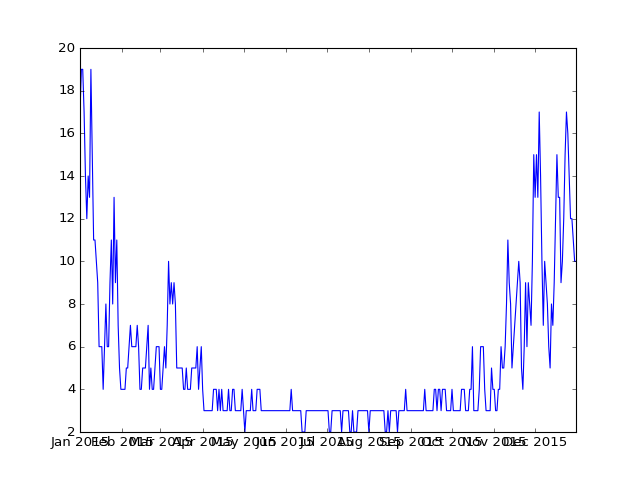

In [40]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure(1)
ax = fig.add_subplot(1,1,1)
ax.plot(days, filtered.measurement)